In [6]:
import pandas as pd
import xarray as xr
import sys
sys.path.append("/home/atuin/c104fa/c104fa10/utils")
import tctools2 as tct
import numpy as np
# import matplotlib.colors as mcolors
# import pickle
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [7]:
precipEventPath = "/home/atuin/c104fa/c104fa10/data/ERA5/precipitation/masks/thresh.001.dist.750/precipmask."
moistureFluxPath = "/home/atuin/c104fa/c104fa10/data/ERA5/moistureFlux700/era5_mf700_d_"
precipMaskPath = "/home/atuin/c104fa/c104fa10/data/ERA5/precipitation/masks/thresh.001.dist.750/precipmask."
precipCompartmentPath = "/home/atuin/c104fa/c104fa10/data/westerlyPrecip/tcv3.ERA5/compartments/compartments."
precipAmountPath = "/home/atuin/c104fa/c104fa10/data/ERA5/precipitation/daily/precipitation.d."
westerlyEventsPath = "/home/atuin/c104fa/c104fa10/data/westerlies/sensitivity/mf700/dir.50_thresh.70_size.1000/data/event."# "/home/atuin/c104fa/c104fa10/data/westerlies/eventDataTCv3/netcdfs/events_"
wPath = "/home/atuin/c104fa/c104fa10/data/ERA5/w/era5_w_"
uvqPath = "/home/atuin/c104fa/c104fa11/ERA5/data/era5_uvq_"
ibtracs = tct.load_IBTrACS(times=[12],basins=["SI","NI"])

Reading TC data from '/home/atuin/c104fa/c104fa10/data/cyclones/ibtracs.since1980.list.v04r00.csv'


In [48]:
def event_plotter_layers(year,month,day,moistureTransport,westerlyEvents,precip,precipMask,compartments,ibtracs,ax=None,saveLoc=None,extent=[0,90,5,-30],layers=["moistureFlux","precip","precipMask","precipCompartments","westerlyMask"]):

    lonMin = extent[0]
    lonMax = extent[1]
    latMin = extent[3]
    latMax = extent[2]

    pddate = np.datetime64(f"{year}-{month:02}-{day:02}")
    pddateNoon = pd.to_datetime(f"{year}-{month:02}-{day:02} 12:00")

    # Define custom boundaries and colormap
    boundaries = np.arange(21)
    cmap = plt.get_cmap('Greys')

    # Use BoundaryNorm to set colors between boundaries
    norm = mcolors.BoundaryNorm(boundaries, cmap.N, extend='max')

    tcWesterly = compartments["tc_westerly_precip"]
    notcWesterly = compartments["noTC_westerly_precip"]
    # compartments = xr.where(compartments < 1, np.nan, compartments)

    if ax is None:

        fig,ax = tct.new_map_axes()
    # Define the text lines and their respective colors
    lines = []

    if "moistureFlux" in layers:
        tct.plot_moisture_transport(year,month,day,kilimanjaro=False,moistureData=moistureTransport,ax=ax) #,tropicalCyclone=ibtracs,kilimanjaro=False)
        # plot a 500 km radius round any TCs
        ibtracs = ibtracs.loc[ibtracs["LON"].between(lonMin,lonMax) & ibtracs["LAT"].between(latMin,latMax) ]

        daytcs = ibtracs.loc[ibtracs["TIME"]==pddateNoon]

        colours = ['lime','red','cyan','gold']

        irow=0
        for index,row in daytcs.iterrows():
            lon = row["LON"]
            lat = row["LAT"]
            label = f"TC {row['NAME']}"
            lons, lats = tct.generate_circle(lon,lat,500)
            ax.scatter(lon,lat,c=colours[irow],label=label)
            ax.plot(lons,lats,c=colours[irow])#,projection=ccrs.PlateCarree)
            irow+=1

        plt.legend(loc="upper left")

    if "precip" in layers:
        precipPlot = precip.sel(time=pddate,method="nearest").plot.contourf(cmap=cmap,norm=norm,add_colorbar=False,ax=ax)#,cbar_kwargs={"shrink":0.6,"label":"Precipitation mm"}
    if "precipMask" in layers:
        precipMask.sel(time=pddate,method="nearest").plot.contourf(cmap=plt.get_cmap("gist_rainbow"),ax=ax,add_colorbar=False,alpha=0.3)
    if "precipCompartments" in layers:
        notcWesterly.sel(time=pddate,method="nearest").plot.contour(cmap="blue",levels=[0,1],hatches=[None,"///"],ax=ax)#,width=1.)
        tcWesterly.sel(time=pddate,method="nearest").plot.contour(cmap="m",levels=[0,1],hatches=[None,"///"],ax=ax)#,lw=1.)
        notcWesterly.sel(time=pddate,method="nearest").plot.contourf(cmap="blue",levels=[0,0.9],hatches=[None,"///"],ax=ax,alpha=0,add_colorbar=False)#,width=1.)
        tcWesterly.sel(time=pddate,method="nearest").plot.contourf(cmap="m",levels=[0,0.9],hatches=[None,"///"],ax=ax,alpha=0,add_colorbar=False)#,lw=1.)
        lines += [("tc_westerly_precip  ","m"),("noTC_westerly_precip","blue")]
    if "westerlyMask" in layers:
        dayWesterlyEvents = westerlyEvents["westerlyMask"].sel(time=pddate,method="nearest")

        dayWesterlyEvents.plot.contour(cmap="black",levels=[0,1],ax=ax) #,width=1.)
        inside = xr.where(dayWesterlyEvents>0,1,np.nan)
        inside.plot.contourf(cmap=plt.get_cmap("Oranges"),levels=[0,0.9,3,5],alpha=0.45,add_colorbar=False,ax=ax,hatches=".")
        # inside.plot.contourf(cmap="black",levels=[0,0.9,1.5,3],alpha=0.45,add_colorbar=False,ax=ax)
        lines += [("westerly moisture   ","orange")]

    ax.set_title(None)
    if len(lines) > 0:
        # Position variables to control text placement
        x_position = 0.02  # Center x-position
        y_position = 0.04  # Start y-position for the first line
        line_spacing = 0.1  # Space between lines

        # Add each line of text with a different color
        for i, (text, color) in enumerate(lines):
            ax.text(
                x_position, y_position + i * line_spacing,  # Position for each line
                text,                                       # Text string
                color=color,                                # Text color
                fontsize=10,                                # Text font size
                ha="left",                                  # Center-align text
                va="bottom",                                # Center-align vertically
                bbox=dict(facecolor="white",                # Background color
                        edgecolor="black",                  # Border color
                        boxstyle="square,pad=0.5"),
                transform=ax.transAxes        # Rounded box style with padding
            )
    
    ax.set_extent(extent)

    if saveLoc is not None:
        print(f"Saving to {saveLoc}")
        plt.savefig(f"{saveLoc}.png")

    if "precip" in layers:
        return precipPlot

In [49]:
year = 2015
month = 1
day = 9

date = np.datetime64(f"{year}-{month:02}-{day:02} 00:00")

# lonMin = 

moisture = xr.open_dataset(f"{moistureFluxPath}{year}{month:02}.nc")#.sel(longitude)
precip = xr.open_dataset(f"{precipAmountPath}{year}{month:02}.nc")["tp"] * 1000
precipMask = np.load(f"{precipMaskPath}{year}{month:02}.npz")["mask"]
precipMask = xr.DataArray(precipMask,precip.coords)
# precipMask = xr.where(precipMask > 0, 1,np.nan)
compartments = xr.open_dataset(f"{precipCompartmentPath}{year}{month:02}.nc") 
westerlyEvents = xr.open_dataset(f"{westerlyEventsPath}{year}{month:02}.nc")

Plotting daily moisture flux for 2015-01-09


AttributeError: 'Axes' object has no attribute 'add_feature'

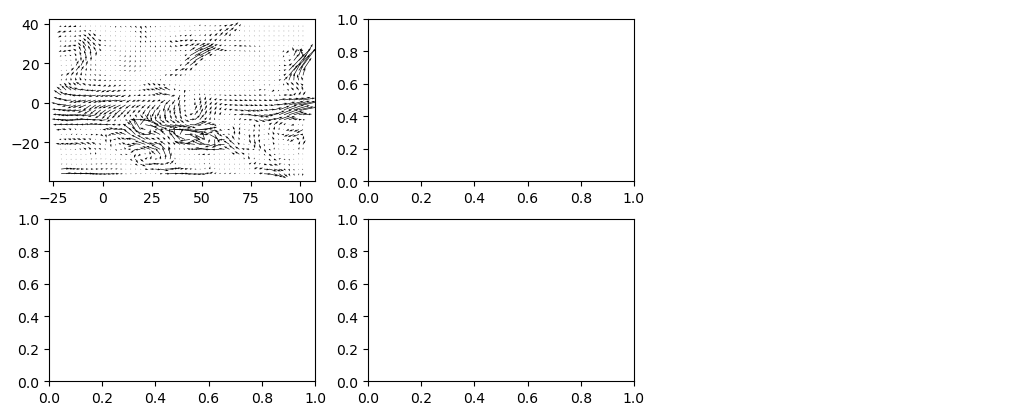

In [58]:
cm = 2.54

figsize = tuple(np.array([17.7,10.7]) / cm)

fig = plt.figure(layout='constrained', figsize=(10, 4))
subfigs = fig.subfigures(1, 2, wspace=0.07, width_ratios=[2, 1])

axsLeft = subfigs[0].subplots(2, 2)

# fig,axs = tct.new_map_axes(nrows=2,ncols=2)

event_plotter_layers(year,month,day,moisture,westerlyEvents,precip,precipMask,compartments,ibtracs,saveLoc =None,layers=["moistureFlux"],ax=axsLeft[0,0])
event_plotter_layers(year,month,day,moisture,westerlyEvents,precip,precipMask,compartments,ibtracs,saveLoc =None,layers=["moistureFlux","westerlyMask"],ax=axsLeft[0,1])

precipPlot = event_plotter_layers(year,month,day,moisture,westerlyEvents,precip,precipMask,compartments,ibtracs,saveLoc =None,layers=["precip"],ax=axsLeft[1,0])
event_plotter_layers(year,month,day,moisture,westerlyEvents,precip,precipMask,compartments,ibtracs,saveLoc =None,layers=["precip","precipMask"],ax=axsLeft[1,1])

plt.colorbar(precipPlot,shrink=0.6,label="Precipitation mm",ax=axsLeft[1],orientation="horizontal",aspect=40)

# print(f"Saving to ")
# plt.savefig(f"{figSaveLoc}.pdf",dpi=dpi,bbox_inches='tight')
# plt.savefig(f"{figSaveLoc}.tif",dpi=dpi,bbox_inches='tight')

dpi = 300

axsRight = subfigs[1].subplots(3, 1, sharex=True)

fig,ax = tct.new_map_axes(nrows=1,ncols=1,figsize=(20,12))
event_plotter_layers(year,month,day,moisture,westerlyEvents,precip,precipMask,compartments,ibtracs,layers=["precipCompartments","precipMask","westerlyMask"],saveLoc=None,ax=ax)

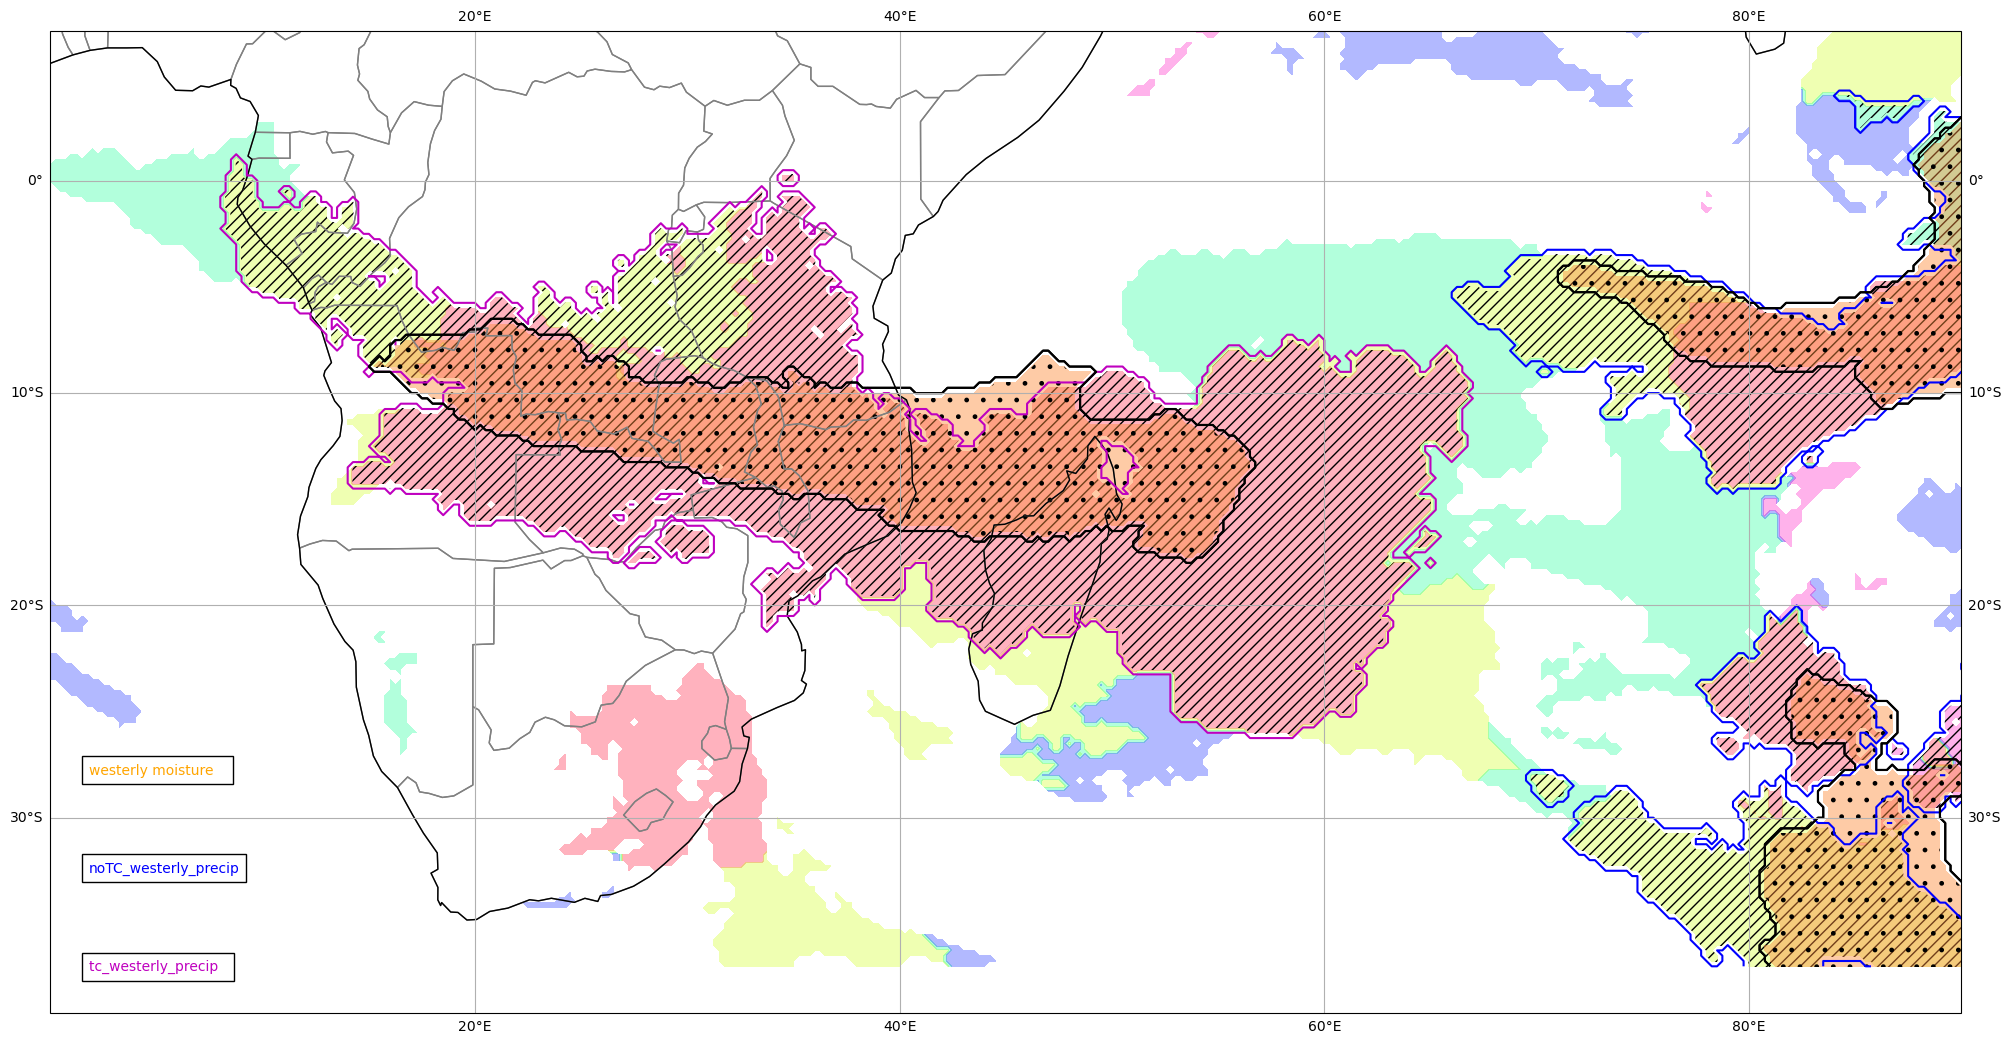

In [51]:
dpi = 300

fig,ax = tct.new_map_axes(nrows=1,ncols=1,figsize=(20,12))
event_plotter_layers(year,month,day,moisture,westerlyEvents,precip,precipMask,compartments,ibtracs,layers=["precipCompartments","precipMask","westerlyMask"],saveLoc=None,ax=ax)

In [10]:
westerlyEventsPath = "/home/atuin/c104fa/c104fa10/data/westerlies/eventDataTCv3/netcdfs/events_"

In [11]:
year = 2018
month = 3
day = 10

date = np.datetime64(f"{year}-{month:02}-{day:02} 00:00")

# lonMin = 

moisture = xr.open_dataset(f"{moistureFluxPath}{year}{month:02}.nc")#.sel(longitude)
precip = xr.open_dataset(f"{precipAmountPath}{year}{month:02}.nc")["tp"] * 1000
precipMask = np.load(f"{precipMaskPath}{year}{month:02}.npz")["mask"]
precipMask = xr.DataArray(precipMask,precip.coords)
# precipMask = xr.where(precipMask > 0, 1,np.nan)
compartments = xr.open_dataset(f"{precipCompartmentPath}{year}{month:02}.nc") 
westerlyEvents = xr.open_dataset(f"{westerlyEventsPath}{year}{month:02}.nc")

Plotting daily moisture flux for 2018-03-10


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Plotting daily moisture flux for 2018-03-10


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


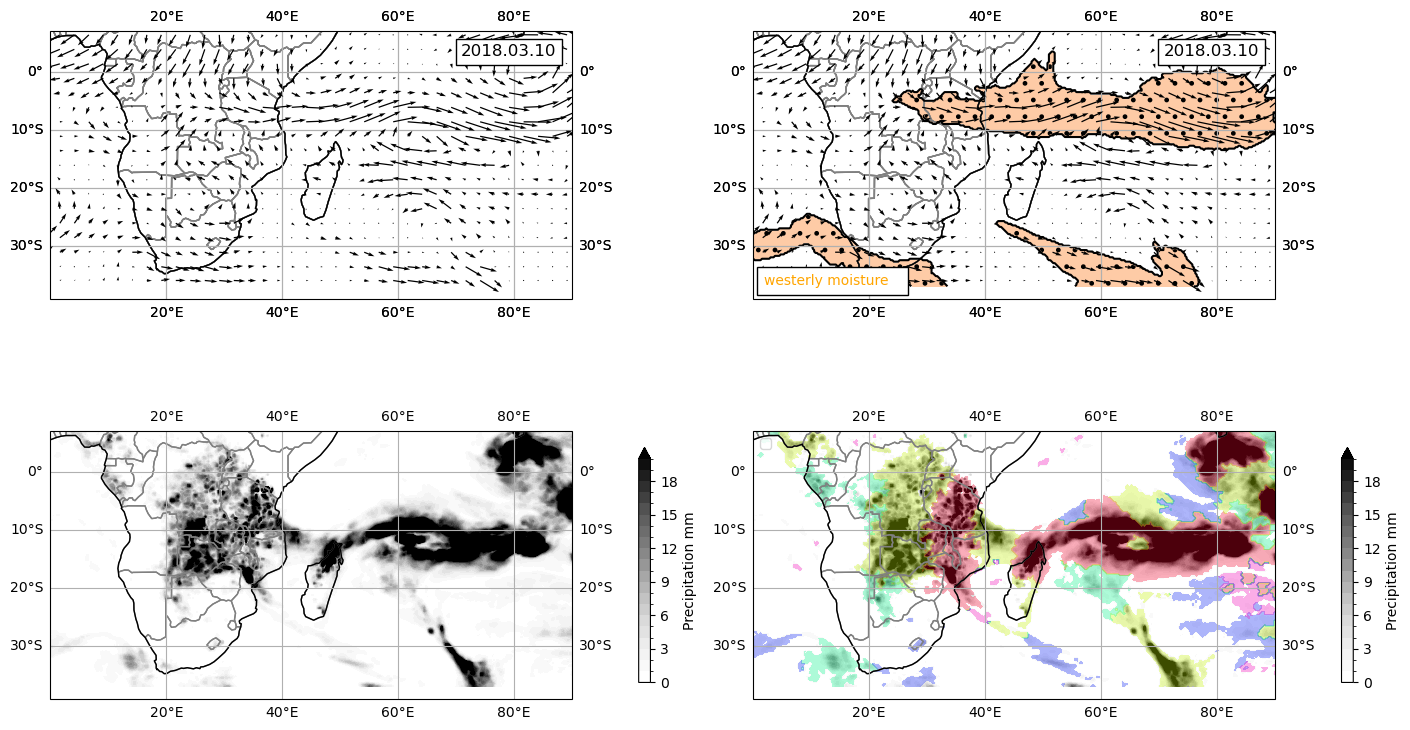

In [12]:
fig,axs = tct.new_map_axes(nrows=2,ncols=2)

event_plotter_layers(year,month,day,moisture,westerlyEvents,precip,precipMask,compartments,ibtracs,saveLoc =None,layers=["moistureFlux"],ax=axs[0,0])
event_plotter_layers(year,month,day,moisture,westerlyEvents,precip,precipMask,compartments,ibtracs,saveLoc =None,layers=["moistureFlux","westerlyMask"],ax=axs[0,1])

event_plotter_layers(year,month,day,moisture,westerlyEvents,precip,precipMask,compartments,ibtracs,saveLoc =None,layers=["precip"],ax=axs[1,0])
event_plotter_layers(year,month,day,moisture,westerlyEvents,precip,precipMask,compartments,ibtracs,saveLoc =None,layers=["precip","precipMask"],ax=axs[1,1])

# print(f"Saving to ")
# plt.savefig(f"{figSaveLoc}.pdf",dpi=dpi,bbox_inches='tight')
# plt.savefig(f"{figSaveLoc}.tif",dpi=dpi,bbox_inches='tight')

Plotting daily moisture flux for 2015-01-10


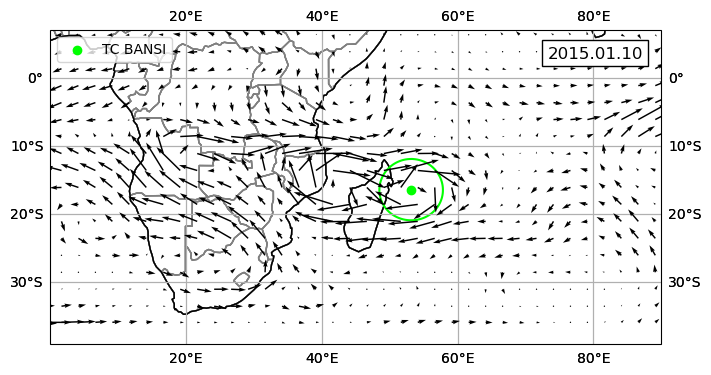

In [41]:
dpi = 300

fig,ax = tct.new_map_axes(nrows=1,ncols=1)
event_plotter_layers(year,month,day,moisture,westerlyEvents,precip,precipMask,compartments,ibtracs,saveLoc =None,layers=["moistureFlux"],ax=ax)
plt.savefig(f"moistureFlux.pdf",dpi=dpi,bbox_inches='tight')
plt.savefig(f"moistureFlux.tif",dpi=dpi,bbox_inches='tight')


Plotting daily moisture flux for 2015-01-10


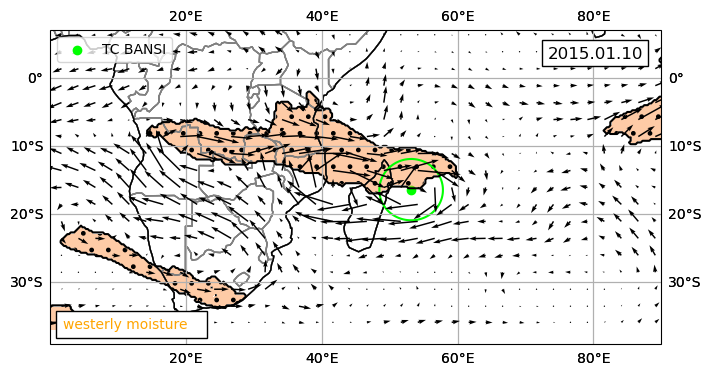

In [42]:
dpi = 300

fig,ax = tct.new_map_axes(nrows=1,ncols=1)
event_plotter_layers(year,month,day,moisture,westerlyEvents,precip,precipMask,compartments,ibtracs,saveLoc =None,layers=["moistureFlux","westerlyMask"],ax=ax)
plt.savefig(f"moistureMask.pdf",dpi=dpi,bbox_inches='tight')
plt.savefig(f"moistureMask.tif",dpi=dpi,bbox_inches='tight')

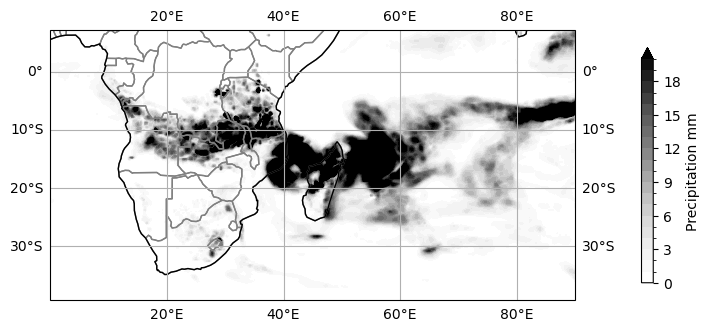

In [43]:
dpi = 300

fig,ax = tct.new_map_axes(nrows=1,ncols=1)
event_plotter_layers(year,month,day,moisture,westerlyEvents,precip,precipMask,compartments,ibtracs,saveLoc =None,layers=["precip"],ax=ax)
plt.savefig(f"precip.pdf",dpi=dpi,bbox_inches='tight')
plt.savefig(f"precip.tif",dpi=dpi,bbox_inches='tight')


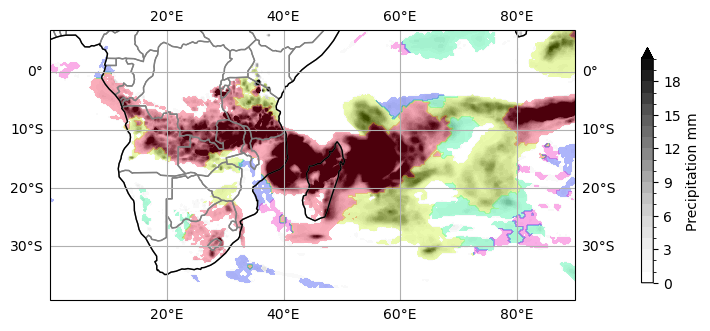

In [45]:
dpi = 300

fig,ax = tct.new_map_axes(nrows=1,ncols=1)
event_plotter_layers(year,month,day,moisture,westerlyEvents,precip,precipMask,compartments,ibtracs,saveLoc =None,layers=["precip","precipMask"],ax=ax)
plt.savefig(f"precipMask.pdf",dpi=dpi,bbox_inches='tight')
plt.savefig(f"precipMask.tif",dpi=dpi,bbox_inches='tight')


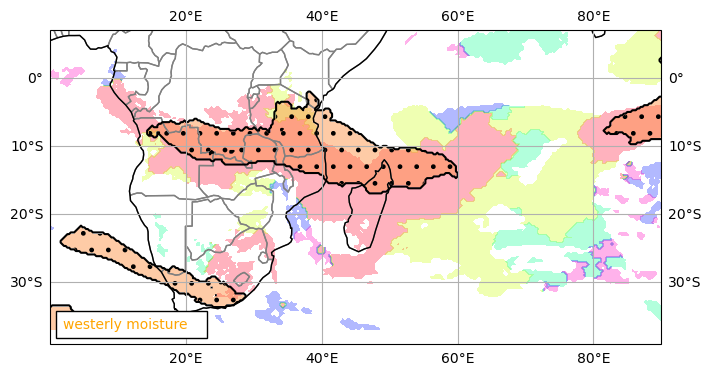

In [48]:
dpi = 300

fig,ax = tct.new_map_axes(nrows=1,ncols=1)
event_plotter_layers(year,month,day,moisture,westerlyEvents,precip,precipMask,compartments,ibtracs,layers=["precipMask","westerlyMask"],saveLoc=None,ax=ax)
plt.savefig(f"overlap.pdf",dpi=dpi,bbox_inches='tight')
plt.savefig(f"overlap.tif",dpi=dpi,bbox_inches='tight')

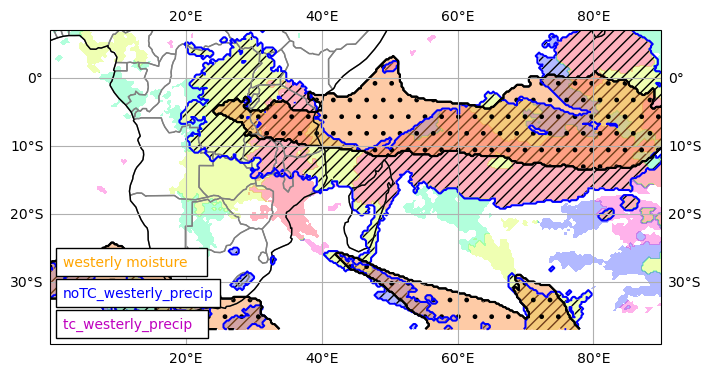

In [21]:
dpi = 300

fig,ax = tct.new_map_axes(nrows=1,ncols=1)
event_plotter_layers(year,month,day,moisture,westerlyEvents,precip,precipMask,compartments,ibtracs,layers=["precipCompartments","precipMask","westerlyMask"],saveLoc=None,ax=ax)
# plt.savefig(f"compartmentMask.pdf",dpi=dpi,bbox_inches='tight')
# plt.savefig(f"compartmentMask.tif",dpi=dpi,bbox_inches='tight')

/home/atuin/c104fa/c104fa10/utils/tctools2.py:963: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(nrows=nrows,ncols=ncols,figsize=figsize,subplot_kw=subplot_kw,constrained_layout=True, **fig_kwargs) # ,projection = ccrs.PlateCarree())


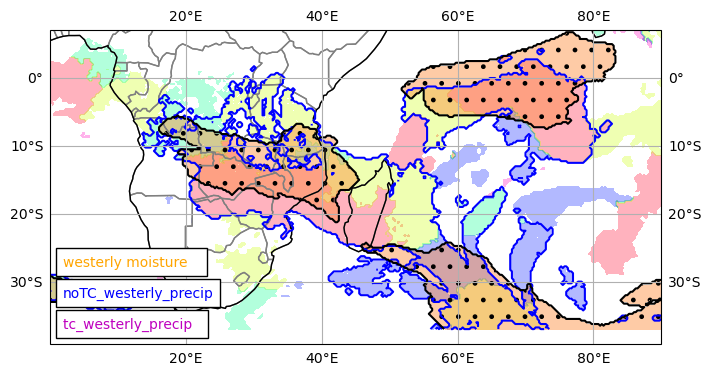

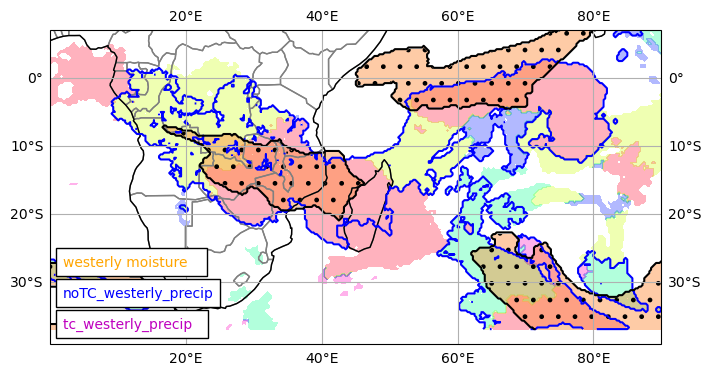

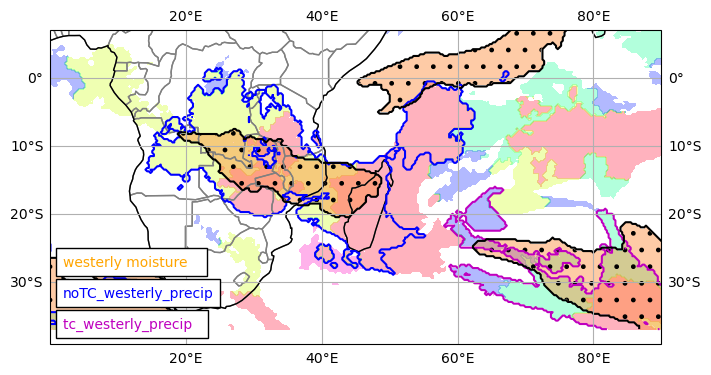

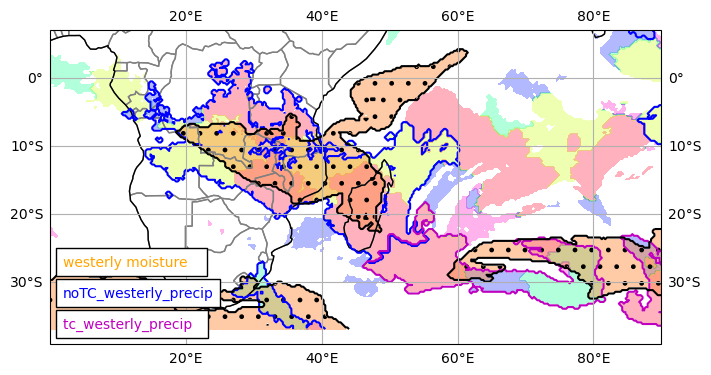

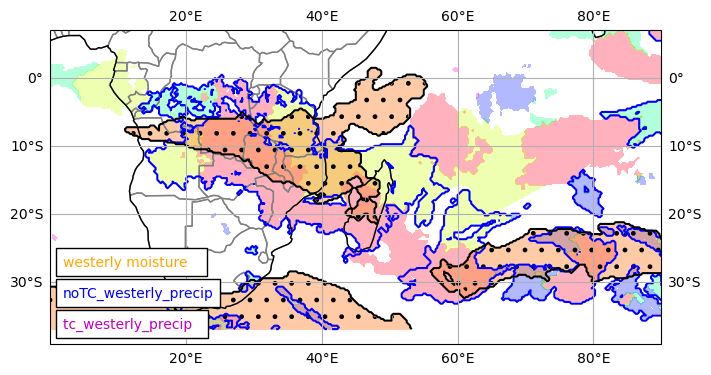

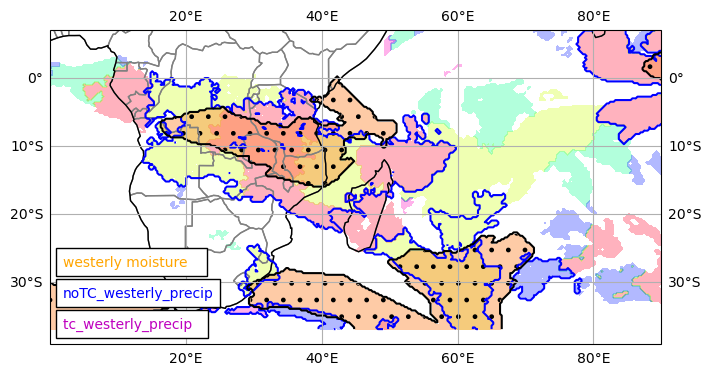

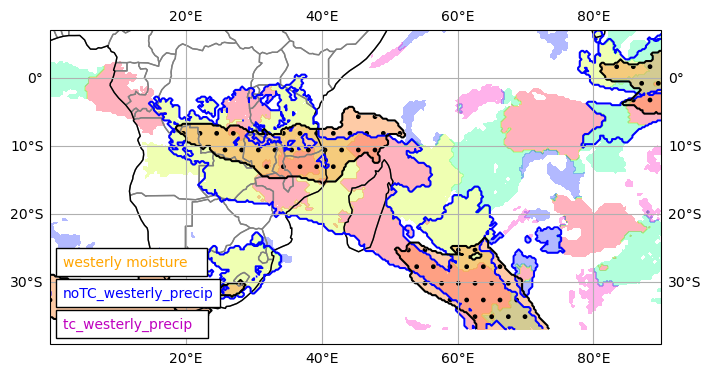

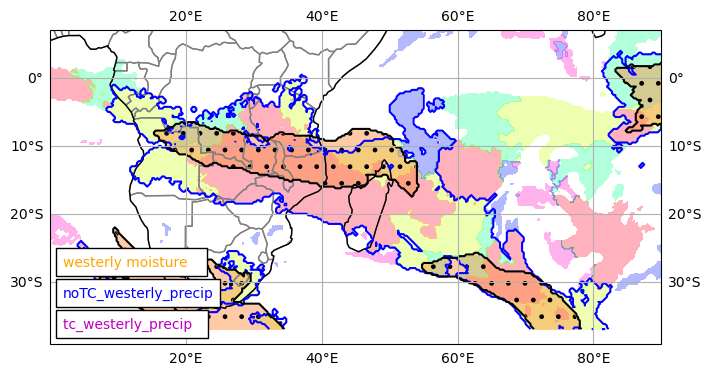

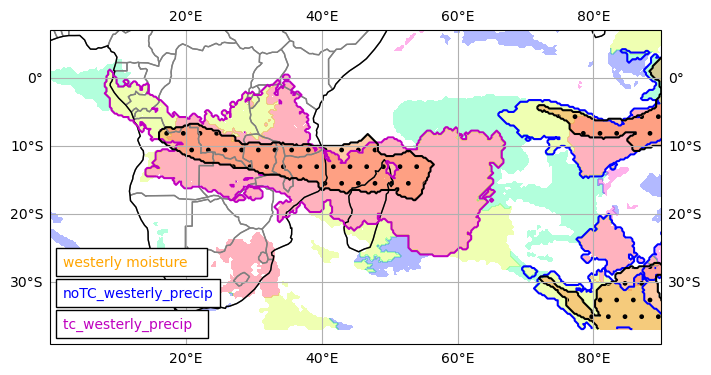

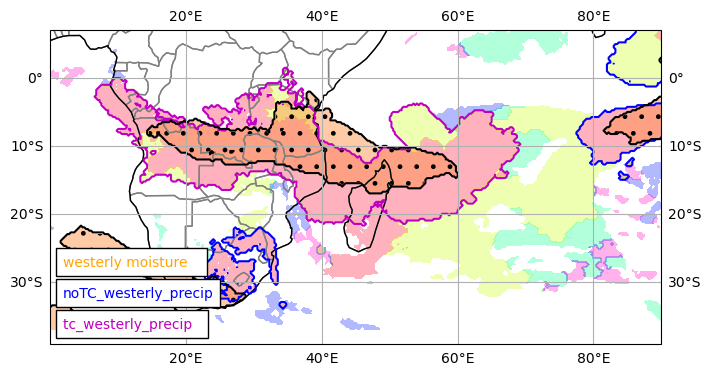

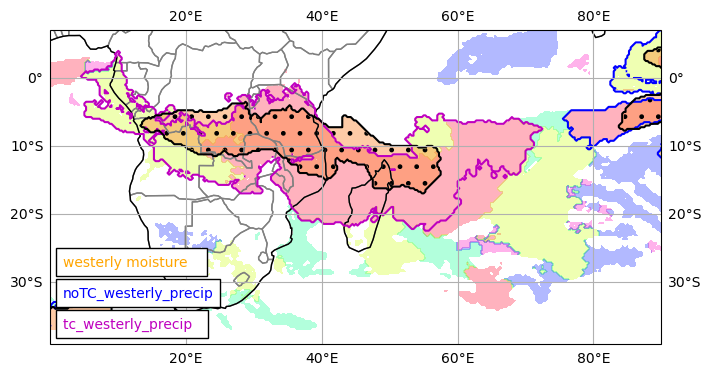

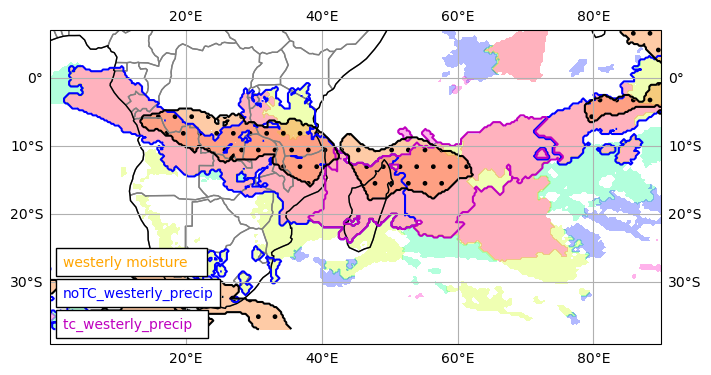

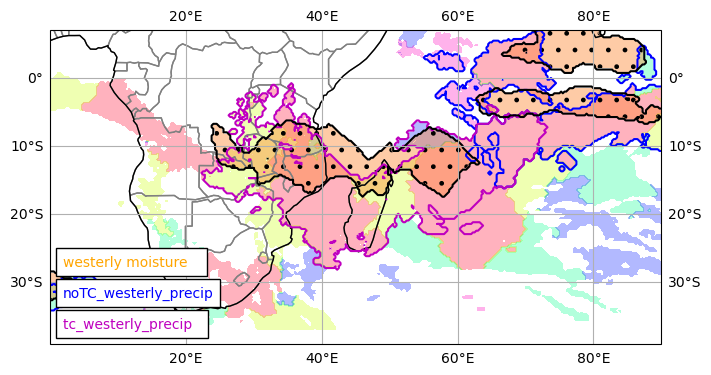

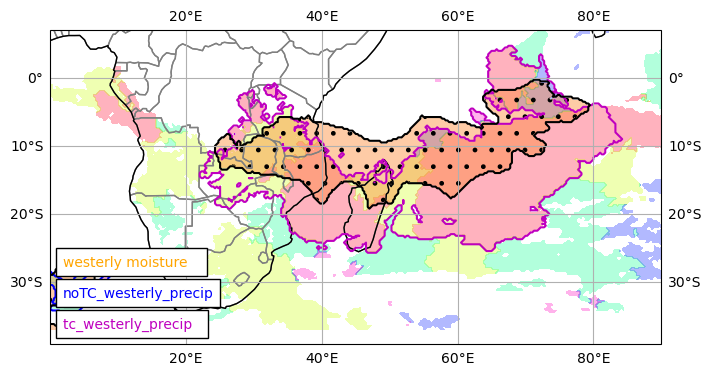

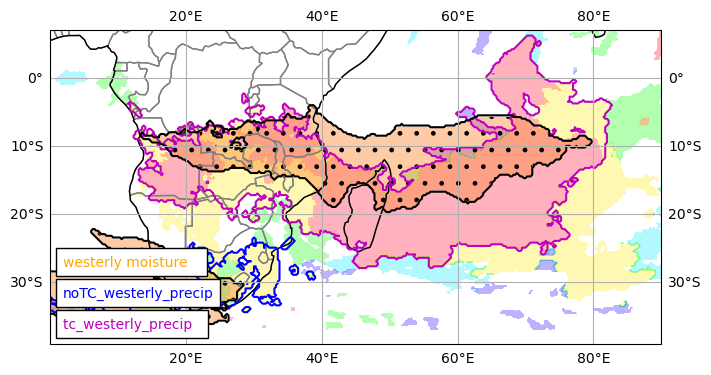

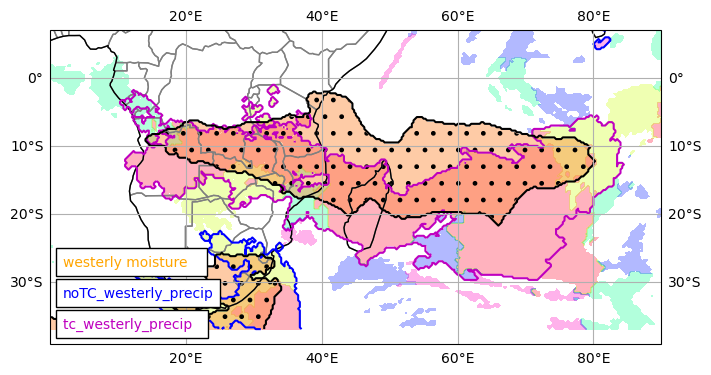

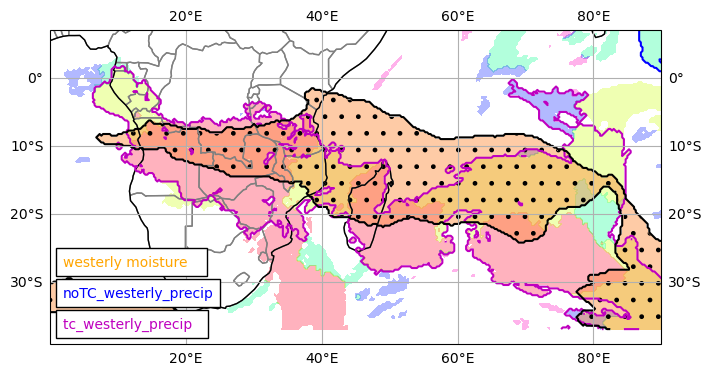

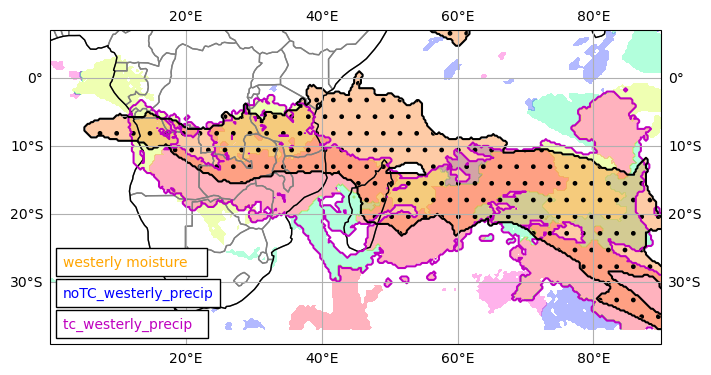

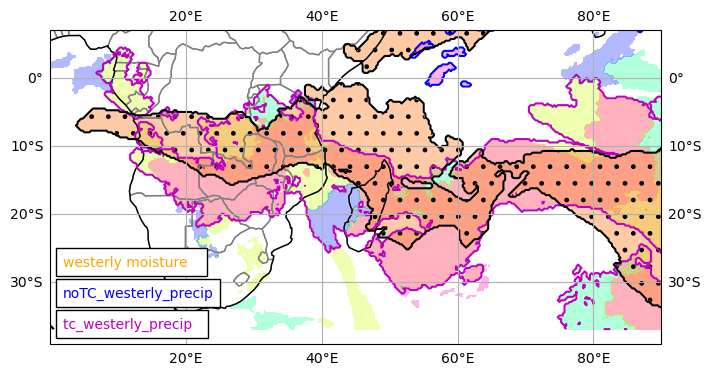

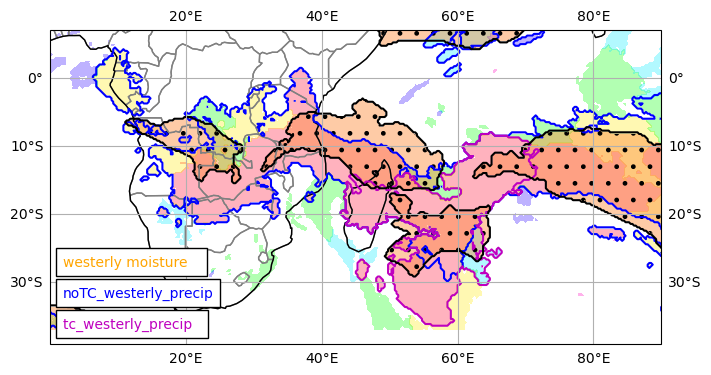

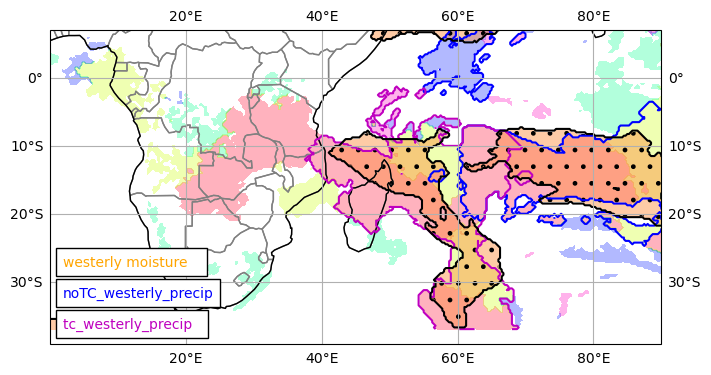

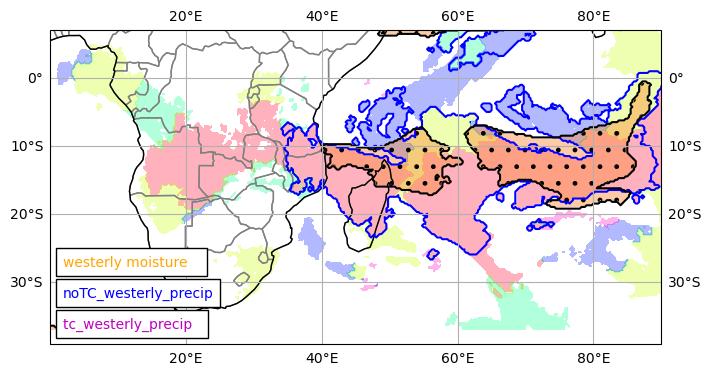

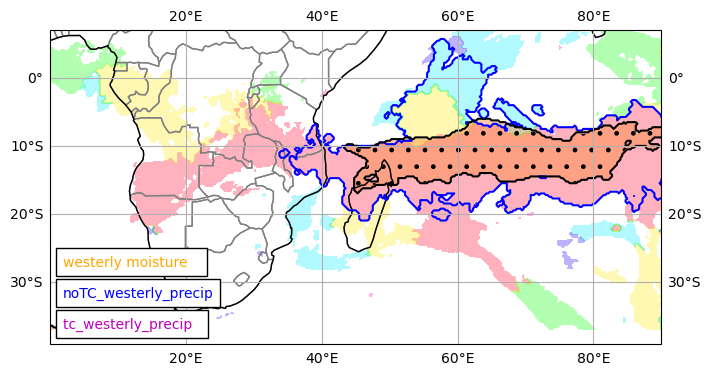

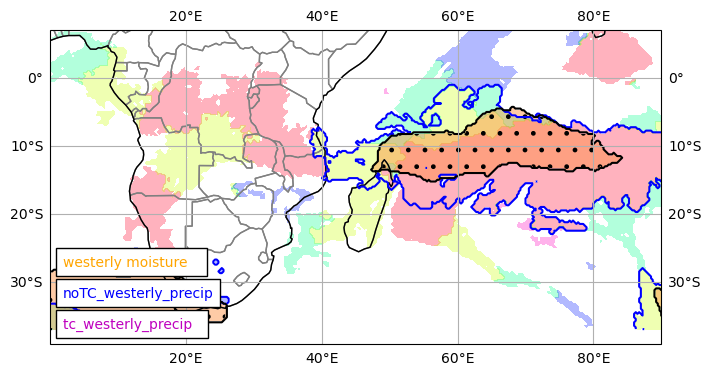

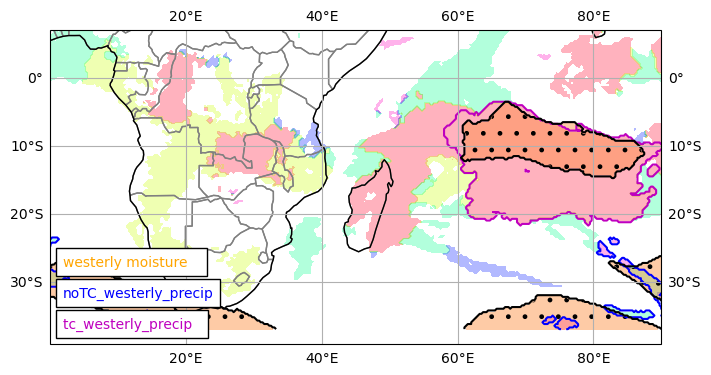

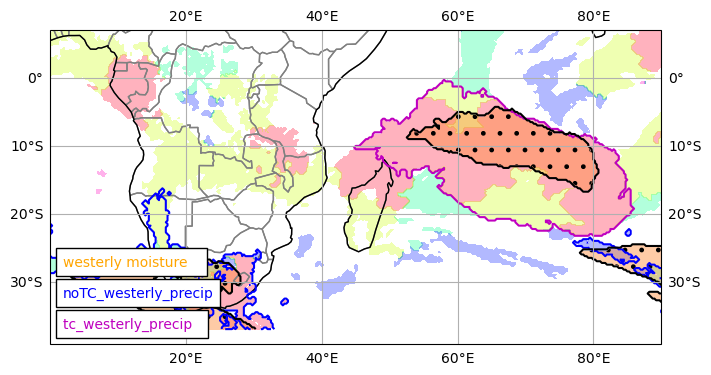

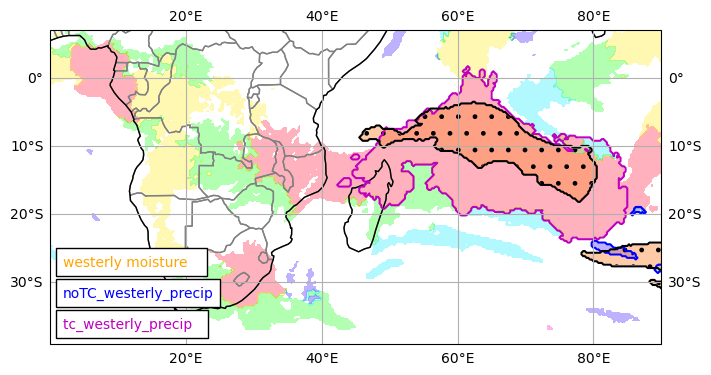

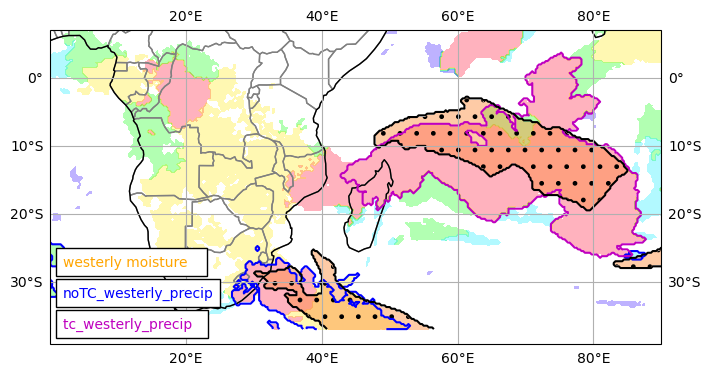

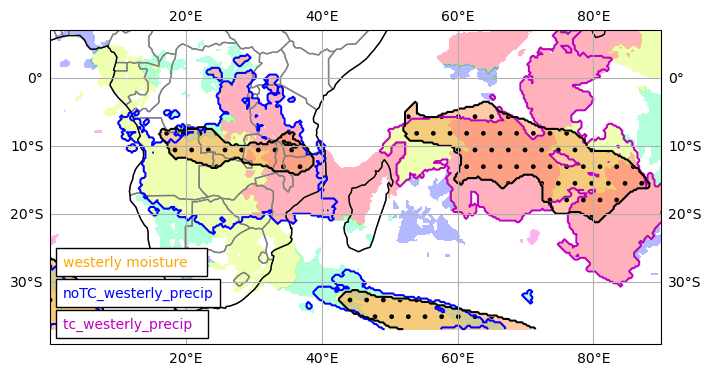

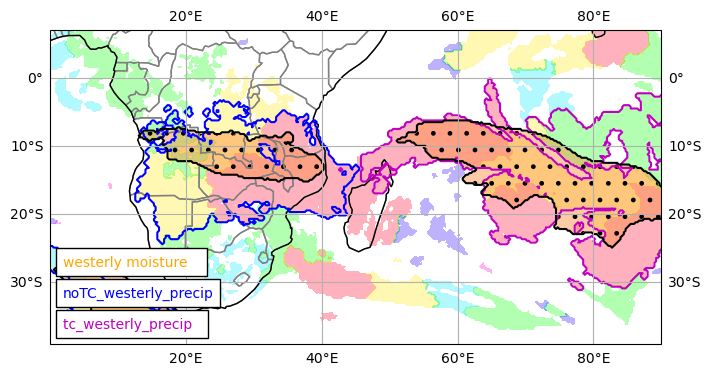

In [29]:
for day in range(1,31):
    event_plotter_layers(year,month,day,moisture,westerlyEvents,precip,precipMask,compartments,ibtracs,layers=["precipCompartments","precipMask","westerlyMask"],saveLoc=None)

Plotting daily moisture flux for 2018-03-28


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Plotting daily moisture flux for 2018-03-28


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


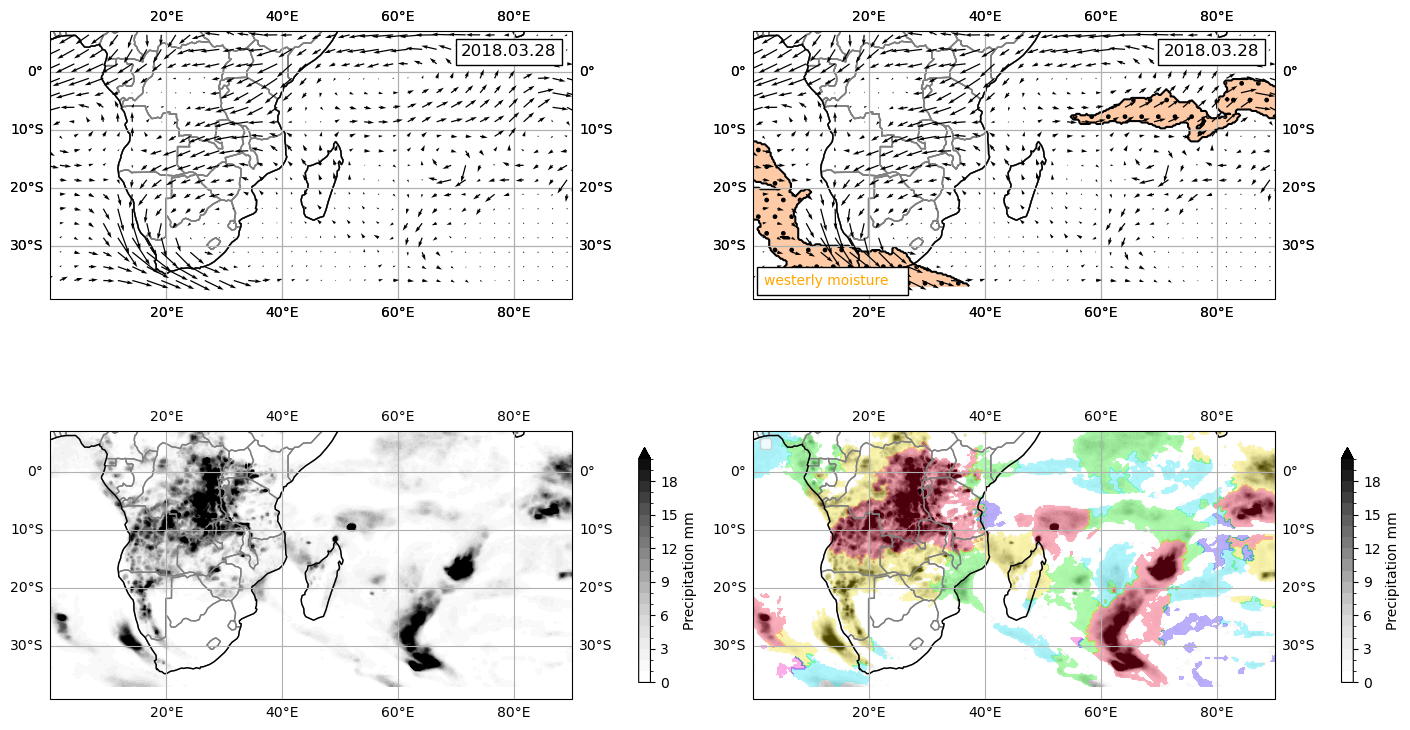

In [ ]:
fig,axs = tct.new_map_axes(nrows=2,ncols=2)

event_plotter_layers(year,month,day,moisture,westerlyEvents,precip,precipMask,compartments,ibtracs,saveLoc =None,layers=["moistureFlux"],ax=axs[0,0])
event_plotter_layers(year,month,day,moisture,westerlyEvents,precip,precipMask,compartments,ibtracs,saveLoc =None,layers=["moistureFlux","westerlyMask"],ax=axs[0,1])

event_plotter_layers(year,month,day,moisture,westerlyEvents,precip,precipMask,compartments,ibtracs,saveLoc =None,layers=["precip"],ax=axs[1,0])
event_plotter_layers(year,month,day,moisture,westerlyEvents,precip,precipMask,compartments,ibtracs,saveLoc =None,layers=["precip","precipMask"],ax=axs[1,1])

Plotting daily moisture flux for 2006-12-24
Reading daily Ivt from /home/atuin/c104fa/c104fa10/data/ERA5/moistureFlux700/era5_mf700_d_200612.nc
Plotting westerly events
Plotting event data
Plotting filters
Plotting: SizeFilter - name: size_filter, min size: 1000
Filter SizeFilter - name: size_filter, min size: 1000 has no plotting procedure
Plotting: PointFilter - name: TC filter , lons: [47.7], lats: [-13.2], max distance: 500 km
Filter PointFilter - name: TC filter , lons: [47.7], lats: [-13.2], max distance: 500 km has no plotting procedure
Done!


(<GeoAxes: xlabel='longitude', ylabel='latitude'>,
 <xarray.Dataset>
 Dimensions:    (longitude: 497, latitude: 309)
 Coordinates:
   * longitude  (longitude) float32 -22.0 -21.75 -21.5 ... 101.5 101.8 102.0
   * latitude   (latitude) float32 40.0 39.75 39.5 39.25 ... -36.5 -36.75 -37.0
     level      int32 700
     time       datetime64[ns] 2006-12-24
 Data variables:
     u          (latitude, longitude) float32 0.02529 0.02284 ... 0.01069 0.01049
     v          (latitude, longitude) float32 0.06159 0.06 ... -0.01401 -0.01347
 Attributes:
     units:          m s^-1
     long_name:      U and V components of moisture flux
     standard_name:  Moisture flux)

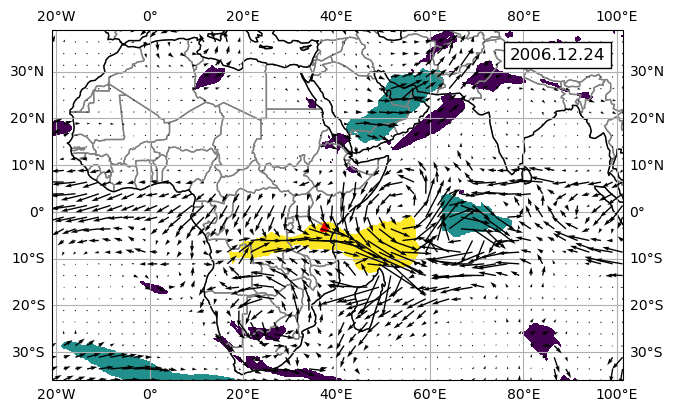

In [62]:
tct.plot_moisture_transport(year,month,day,events="/home/atuin/c104fa/c104fa10/data/westerlies/eventDataTCv3/event_")

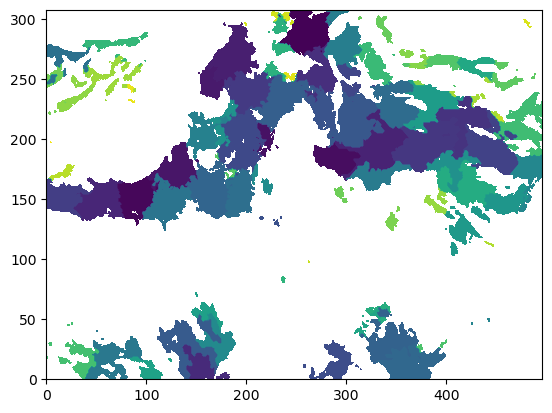

In [35]:
plt.contourf(f["mask"][0],levels=np.arange(80))

In [33]:
np.unique(f["mask"][0])

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52.,
       53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64., 65.,
       66., 67., 68., 69., 70., 71., 72., 73., 74., 75., 76., 77., 78.,
       nan])

In [47]:
mask = precip.copy(deep=True).values = f["mask"]

In [50]:
precip

<xarray.DataArray 'tp' (time: 28, latitude: 309, longitude: 497)>
array([[[4.57435340e-01, 4.24045920e-01, 4.48531508e-01, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [5.23101278e-02, 1.06846213e-01, 3.32781434e-01, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.39122680e-01, 9.68293846e-02, 7.67957196e-02, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [1.34670764e-01, 1.11298144e-01, 8.45865905e-02, ...,
         4.52983439e-01, 4.12916094e-01, 3.93995434e-01],
        [1.82528958e-01, 1.40235662e-01, 1.04620256e-01, ...,
         3.68396848e-01, 3.57267052e-01, 3.71735811e-01],
        [2.89375156e-01, 2.53759772e-01, 2.10353494e-01, ...,
         3.36120397e-01, 3.37233365e-01, 3.16086709e-01]],

       [[3.53594184e+00, 3.69732428e+00, 3.61607671e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [3.23988891e+00, 3.69509816e+00, 3.29553795e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [2.25267434e+00, 2.49196553e+00, 2.91155934e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
...
        [1.73625097e-01, 1.39122680e-01, 1.95884734e-01, ...,
         1.35672426e+00, 9.79423642e-01, 8.29171181e-01],
        [6.56659007e-01, 5.52038789e-01, 5.00841677e-01, ...,
         1.08404386e+00, 8.30284119e-01, 6.83370590e-01],
        [1.64832544e+00, 1.60380626e+00, 1.25655603e+00, ...,
         8.09137464e-01, 5.89880168e-01, 5.69846511e-01]],

       [[1.11298142e-02, 6.67788833e-03, 8.90385173e-03, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.44687584e-02, 1.44687584e-02, 1.11298142e-02, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [2.33726092e-02, 2.11466476e-02, 1.11298142e-02, ...,
         2.22596293e-03, 1.11298147e-03, 1.11298147e-03],
        ...,
        [5.05182266e+00, 5.02845001e+00, 4.84480810e+00, ...,
         9.57164049e-01, 1.10964239e+00, 1.36006331e+00],
        [6.17036915e+00, 5.92439985e+00, 6.24493885e+00, ...,
         1.25878203e+00, 8.71464431e-01, 8.50317836e-01],
        [6.83259296e+00, 7.25886488e+00, 7.49147797e+00, ...,
         1.52701044e+00, 1.13969302e+00, 1.02282989e+00]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 2014-02-01T11:00:00 ... 2014-02-28T11:00:00
  * longitude  (longitude) float32 -22.0 -21.75 -21.5 ... 101.5 101.8 102.0
  * latitude   (latitude) float32 40.0 39.75 39.5 39.25 ... -36.5 -36.75 -37.0